In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sqlite3 as sql

# Joining Data

First, we load the raw cellphone data and convert it. this is using the same code I made in the last homework, where NaNs are forward-filled.

In [2]:
cell = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/cell_phones_total.csv")
cell.set_index("iso-3", inplace = True)
for col in cell:
    if len(cell[col].unique()) <= 2:
        cell[col].fillna(0, inplace= True)
        
def str_to_number(x, sizes = {"k" : 10**3, "K" : 10**3
                     , "m" : 10**6, "M": 10**6
                     , "b": 10**9, "B" : 10**9}):
    
    # Takes a number expressed in the form (number)(letter) and converts it into the corresponding number using the "sizes dictionary"
    
    num = re.match(r"[0-9\.]+" , str(x))
    l = re.search(r".$", str(x))
    
    # If both num and l are successful matches, we have a string of the correct form to convert
    if num and l:
        # accessing the strings we found
        num = num.group(0)
        l = l.group(0)
        
        # adding the results as a number
        if l in sizes.keys():
                return float(num) * sizes[l]
        else: 
                return float(num)

    else:
        return float(x)
        
def df_to_numbers(df):
    return df.map(str_to_number, na_action = "ignore")
    
cell = df_to_numbers(cell)
cell.ffill(axis = 1, inplace = True)


Now let's load the population data and inspect it.

In [3]:
pop = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv").drop(columns = "Unnamed: 0").set_index("iso-3")
pop.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
iso-3,,,,,,,,,,,,,,,,,,,,,
ABW,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,59522.0,59471.0,59330.0,...,101288.0,102112.0,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0
AFE,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,153955516.0,158313235.0,162875171.0,167596160.0,...,537792950.0,552530654.0,567892149.0,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0
AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,10247780.0,10494489.0,...,29249157.0,30466479.0,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0
AFW,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,110798486.0,113319950.0,115921723.0,118615741.0,...,366489204.0,376797999.0,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0
AGO,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,5827503.0,5868203.0,5928386.0,...,24259111.0,25188292.0,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0


There are no large swathes of missing values like in the cell phone data, so we'll have to take a closer look to find the missing values. In the following code i pick all rows that have at least one missing value.

In [4]:
pop[pop.isnull().any(axis=1)]

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
iso-3,,,,,,,,,,,,,,,,,,,,,
INX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3882986.0,3979998.0,4076708.0,4173398.0,4270092.0,4367088.0,4454805.0,4569087.0,4685306.0,4803269.0


Only two rows have any missing values, meaning all others already have workable data. Now we have to decide what to do with these two rows. First let's take acloser look at `INX`.

In [5]:
pop.loc[pop.index == "INX"].squeeze().unique()

array([nan])

We can see that`INX` has not a single non-`NaN` value in it. As such, we have no information to interpolate or otherwise fix the data, we will have to remove the row.

Next we'll take a look at the data for `PSE`. This is the country code for Palestine, which according to wikipedia declared their independance 1988. This explains what we see if we remove the `Nan` values.

In [6]:
pop.loc[pop.index == "PSE"].squeeze().dropna()

1990    1978248.0
1991    2068845.0
1992    2163591.0
1993    2262676.0
1994    2366298.0
1995    2474666.0
1996    2587997.0
1997    2706518.0
1998    2776568.0
1999    2848431.0
2000    2922153.0
2001    2997784.0
2002    3075373.0
2003    3154969.0
2004    3236626.0
2005    3320396.0
2006    3406334.0
2007    3494496.0
2008    3591977.0
2009    3689099.0
2010    3786161.0
2011    3882986.0
2012    3979998.0
2013    4076708.0
2014    4173398.0
2015    4270092.0
2016    4367088.0
2017    4454805.0
2018    4569087.0
2019    4685306.0
2020    4803269.0
Name: PSE, dtype: float64

The `NaN` values end in 1990, just after Palestine declared independance. Thus, it is reasonable to set these values to 0, as there was no state of Palestine before then. However, for 1988 and 1989, I will backfill these values with the value for 1990.

In [7]:
# backfill 1988 and 1989
pop["PSE"] = pop.loc[pop.index == "PSE"].squeeze().bfill(limit = 2)
# Remove INX and fill NaNs of PSE
pop = pop.drop(axis = 0, index = "INX").fillna(0)

Now to merge our two dataframes we give them a common name for their collumns; "year", and pivot them to the same long format.

In [8]:
# give columns name
pop.columns.name = "year"
cell.columns.name = "year"
newdf = pd.merge(cell.stack().reset_index().rename(columns={0: "n_cellphones"}),
                 pop.stack().reset_index().rename(columns={0: "population"}))
newdf.head()

,iso-3,year,n_cellphones,population
0,ABW,1960,0.0,54608.0
1,ABW,1965,0.0,58782.0
2,ABW,1966,0.0,59291.0
3,ABW,1967,0.0,59522.0
4,ABW,1968,0.0,59471.0


To change `iso-3` to the corresponding country names: we load the country data that pairs them and merge (changing columns names from country data as needed). This way we have a column of country names that matches with the iso-3 names.

In [9]:
count = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv")[["name","alpha-3"]]
count.rename(columns={"alpha-3":"iso-3","name":"country"}, inplace = 1)
newdf = pd.merge(newdf,count)
newdf.head()

,iso-3,year,n_cellphones,population,country
0,ABW,1960,0.0,54608.0,Aruba
1,ABW,1965,0.0,58782.0,Aruba
2,ABW,1966,0.0,59291.0,Aruba
3,ABW,1967,0.0,59522.0,Aruba
4,ABW,1968,0.0,59471.0,Aruba


Now we  add a column with cellphones per person (it is unnamed since we won't need a name soon). Then we remove the three columns we no longer need. We also set the index to be a multi-index of year and country so we can unstack it later.

In [10]:
newdf[""] = newdf["n_cellphones"] / newdf["population"]
newdf.drop(columns=["n_cellphones","population","iso-3"],inplace = True)
newdf.set_index(["year","country"], inplace = True)
newdf.head()

,,
year,country,
1960,Aruba,0.0
1965,Aruba,0.0
1966,Aruba,0.0
1967,Aruba,0.0
1968,Aruba,0.0


The following is to make the columns we get after unstacking into values instead of tuples. I have no idea why, but unstacking gives us multi-index columns of the form ("",country). This way we can easily select columns later.

In [11]:
newdf = newdf.unstack()
newdf.columns = newdf.columns.get_level_values(1)
newdf.head()

country,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Virgin Islands (British),Virgin Islands (U.S.),Yemen,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, to produce the table that was asked for, we find the countries with the five highest phone-to-person ratio by sqeezing our row for 2019 and finding the three biggest values.

In [12]:
newdf.loc[newdf.index == "2019"]\
    .squeeze()\
    .sort_values(ascending = False)\
    .head()

country
Macao                   3.284849
Hong Kong               2.863650
United Arab Emirates    2.127739
Antigua and Barbuda     1.997460
Seychelles              1.987196
Name: 2019, dtype: float64

Now we can select these five countries and get the table

In [13]:
newdf[["Macao","Hong Kong","United Arab Emirates","Antigua and Barbuda","Seychelles"]].tail()

country,Macao,Hong Kong,United Arab Emirates,Antigua and Barbuda,Seychelles
year,,,,,
2015,3.088231,2.290401,2.007424,1.956838,1.584260
2016,3.143510,2.398931,2.212521,1.987545,1.605459
2017,3.210102,2.488773,2.183431,2.019337,1.742433
2018,3.348741,2.670209,2.199084,2.008164,1.849900
2019,3.284849,2.863650,2.127739,1.997460,1.987196


Let's plot these and see what we find

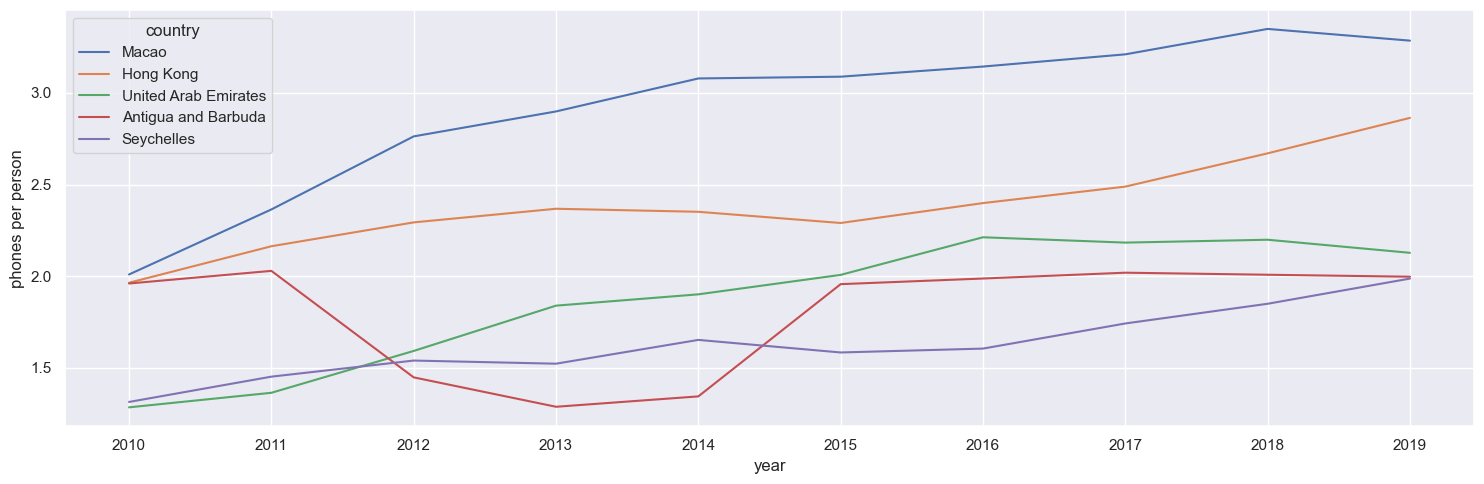

In [36]:
sns.set_theme()

fig, ax = plt.subplots(figsize = (15,5))

# I do some tomfoolery with the dataframe to get the right format
sns.lineplot(newdf[-10:][["Macao","Hong Kong","United Arab Emirates","Antigua and Barbuda","Seychelles"]] \
             .melt(var_name="country", value_name="phones per person", ignore_index = False)
             , x = "year", y = "phones per person", hue = "country", ax = ax)
fig.tight_layout()


It seems that Macao and Hong Kong are the top two for this entire period, with a steady increase in phones per capita. The United Arab Emirates and Seychelles had a similar absolute increase, but with a noticably lower starting value, had larger growth factors. The lowest increase was Antigua and Barbuda, which started and ended at nearly the same amount. Interestingly, the country al

# SQL

First, let's connect to the database and create our cursor.

In [37]:
conn = sql.connect("user_actions.db")
cursor = conn.cursor()

Now we'll take a look at our database and see what our variables are (not sure how to fins these names normally but fetching from master gives it).

In [43]:
query = """
SELECT *
FROM sqlite_master
"""
cursor.execute(query)
cursor.fetchone()

('table',
 'user_actions',
 'user_actions',
 2,
 'CREATE TABLE user_actions (\n    user_id INTEGER,\n    username TEXT,\n    email TEXT,\n    action TEXT,\n    timestamp TEXT\n)')

The last value shows the five variables we have to work with. If we fetch from the data we see some examples of entries.

In [40]:
query = """
SELECT *
FROM user_actions
"""
cursor.execute(query)
for data in cursor.fetchmany(5):
    print(data)

(34, 'user34', 'user34@email.com', 'signup', '2015-02-04 14:38:47')
(28, 'user28', 'user28@email.com', 'signup', '2015-03-09 11:55:33')
(27, 'user27', 'user27@email.com', 'login', '2015-04-17 14:48:31')
(27, 'user27', 'user27@email.com', 'login', '2015-04-21 13:22:14')
(27, 'user27', 'user27@email.com', 'reset_password', '2015-04-25 16:30:15')


To find those that have signed up is simple, we just add a condition to our query and add all names we see in the entries.

In [25]:
query = """
SELECT *
FROM user_actions
WHERE action = "signup"
"""
cursor.execute(query)

names_signup = []
for data in cursor.fetchall():
    # data[1] is the username variable
    name = data[1]
    if name not in names_signup:
        names_signup.append(name)
names_signup

['user34',
 'user28',
 'user1',
 'user24',
 'user15',
 'user20',
 'user18',
 'user25',
 'user3',
 'user9',
 'user27',
 'user16',
 'user17',
 'user4',
 'user8',
 'user13',
 'user19',
 'user31',
 'user10',
 'user23',
 'user11',
 'user33',
 'user12',
 'user29',
 'user21',
 'user6',
 'user14',
 'user30',
 'user7',
 'user26',
 'user22',
 'user5',
 'user35',
 'user2',
 'user32']

If we want to count the number of log entries per user we can make a dictionary with names as keys and increment its value everytime that name appears in an entry.

In [191]:
query = """
SELECT *
FROM user_actions
"""
cursor.execute(query)


count = {}
for data in cursor.fetchall():
    name = data[1]
    if name not in count.keys():
        count[name] = 1
    else:
        count[name] += 1
        
pd.Series(count).sort_values(ascending = False)

user13    470
user6     457
user4     436
user35    394
user31    389
user16    379
user17    367
user20    362
user7     362
user8     329
user11    328
user21    323
user14    320
user23    309
user22    275
user26    217
user27    211
user12    209
user5     192
user34    180
user10    170
user30    165
user24    162
user2     149
user25    136
user18    122
user9     118
user3     108
user1     104
user28     91
user19     58
user29     49
user15     35
user33     32
user32     32
dtype: int64

To find all users who logged in and signed up in the same day can be done by ordering by timestamp in our query. Now all entries on the same day are quaranteed to appear next to eachother(Remember that the format of the timestamps have the date first.). My algorithm to find the users is easier to explain by in-code comments.

In [47]:
query = """
SELECT *
FROM user_actions
WHERE action = "signup" OR action = "login"
ORDER BY timestamp
"""
cursor.execute(query)

users = []
temp = {}
date = ""

for data in cursor.fetchall():
    
    # Once a new day rolls around, we discard all entries we looked at previously
    # All timestamps have the format "YYYY-MM-DD timestamp", so the first 10 characters have the date, and we slice the timestamp there
    if data[4][:10] != date:
        temp = {}
        date = data[4][:10]
        
    user = data[:2]
    action = data[3]
    
    # If this is the first action by the user this day, we add the user and action to the dictionary   
    if user not in temp.keys():
        temp[user] = action
    # If this is not the first action, see if it is a different action (and therefore the other of the two needed in the day)
    # add this user to the permanent list
    elif action != temp[user] and user not in users:
        users.append(user)
    
users

[(8, 'user8'),
 (12, 'user12'),
 (30, 'user30'),
 (7, 'user7'),
 (22, 'user22'),
 (5, 'user5'),
 (2, 'user2'),
 (32, 'user32')]

While I could have logically assumed that a signup has to appear before a login, I decided to follow the assignment more literally and ignored order.

# Regex

First we load the text document into a list of each line

In [48]:
with open("comments.txt", "r") as f:
    comments = f.read()
    comments = comments.split("\n")

To find all instances of a hashtag in a string we use the `re.findall` function with the regular expression `r"#\w+"`. This matches any part of the string that has a hashtag followed by one or more word characters. As the character `+` is "greedy" it matches as many characters as possible, and so only matches the full hashtag.

In [60]:
re.findall(r"#\w+", comments[0])

['#programming', '#tips']

To find a full string that has both `#programming` and `#python` in it I use `r.fullmatch`, which checks if the whole string metches the expression (you could also use `^` at the beginning and `$` at the end of the expression to get the same result.). The actual expression i used simply checks for either "#python" followed by "#programming" or "#programming" followed by "#python" somewhere in the string. There is definitely a more elegant and generalizable solution to this problem, but this works.

In [63]:
re.fullmatch(r"(.*#python.*#programming.*)|(.*#python.*#programming.*)", comments[1], re.I)

In this case no match is made since comment 2 does not contain both of those hashtags. To show that it works we try it on another comment

In [73]:
print("comment: " + comments[5])
print("regex: " + re.fullmatch(r"(.*#python.*#programming.*)|(.*#programming.*#python.*)", comments[5], re.I).group(0))

comment: 6. "I learned a lot. #programming #python #tips"
regex: 6. "I learned a lot. #programming #python #tips"


To extract all hashtags from our text I simply loop though all lines of text and use our previously made hashtag-finder, and then add the hashtags to a list if it is not already there.

In [49]:
hashtags = []

for s in comments:
    matches = re.findall(r"#\w+", s)
    for m in matches:
        if m not in hashtags:
            hashtags.append(m)
            
hashtags

['#programming',
 '#tips',
 '#coding',
 '#python',
 '#tech',
 '#data',
 '#analysis',
 '#innovation',
 '#analytics',
 '#insights',
 '#research']